In [1]:
# !pip install pyspark

In [1]:
import threading
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import queue
from concurrent.futures import ThreadPoolExecutor
import multiprocessing as mp
import asyncio
import networkx as nx
from pyspark import SparkContext

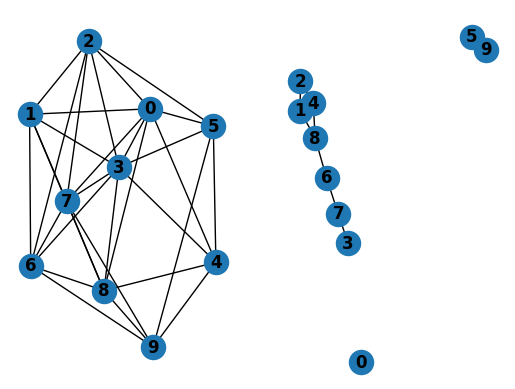

In [2]:
G1 = nx.gnp_random_graph(10, 0.5, directed=False)
G2 = nx.gnp_random_graph(10, 0.15, directed=False)

plt.subplot(121)
nx.draw(G1, with_labels=True, font_weight='bold')
plt.subplot(122)
nx.draw(G2, with_labels=True, font_weight='bold')
plt.show()

In [4]:
sc = SparkContext('local', 'test')

# Assuming G is a NetworkX graph
# Extracting data from the graph
edges_list = [(u, v) for u, v in G1.edges(data=False)]

# Creating an RDD from the list of edges
edges_rdd = sc.parallelize(edges_list)

23/11/15 16:14:53 WARN Utils: Your hostname, coartix-ubuntu resolves to a loopback address: 127.0.1.1; using 10.41.178.221 instead (on interface wlp0s20f3)
23/11/15 16:14:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/15 16:14:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/15 16:14:55 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [28]:
def bronKerbosch1_parallel(R, P, X, G):
    if len(P) == 0 and len(X) == 0:
        return [R]
    
    results = []
    for v in P.copy():
        subgraph = G.subgraph(P.intersection(set(G.neighbors(v))).union({v}))
        subresult = bronKerbosch1_parallel(R.union({v}), P.intersection(set(G.neighbors(v))), X.intersection(set(G.neighbors(v))), subgraph)
        results.extend(subresult)
        P.remove(v)
        X.add(v)
    
    return results

def parallel_bronKerbosch(sc, graph):
    nodes = list(graph.nodes())
    
    # Broadcast the graph to all workers
    broadcast_graph = sc.broadcast(graph)
    # Parallelize the nodes
    parallel_nodes = sc.parallelize(nodes)
    
    # Use map to apply the function in parallel
    result_rdd = parallel_nodes.map(lambda v: bronKerbosch1_parallel({v}, set(graph.neighbors(v)), set(), broadcast_graph.value))

    # List of sets
    results = [item for sublist in result_rdd.collect() for item in sublist]
    # Return the list of unique sets transposed as a list
    return list(map(set, set(map(frozenset, results))))

In [29]:
print(parallel_bronKerbosch(sc, G1))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[{8, 2, 4, 7}, {9, 6}, {1, 7}, {8, 4, 7}, {8, 5, 6}, {2, 4, 5}, {0, 2, 5}, {8, 2, 7}, {3, 5, 6}, {2, 4, 7}, {0, 8, 2, 5}, {8, 2, 4, 5}, {8, 2, 5}, {0, 9, 2}, {1, 5, 6}, {8, 4, 5}]
